In [ ]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
# Dinh nghia cac bien

gestures = {'L_': 'L',
           'fi': 'E',
           'ok': 'F',
           'pe': 'V',
           'pa': 'B'
            }

gestures_map = {'E': 0,
                'L': 1,
                'F': 2,
                'V': 3,
                'B': 4
                }


gesture_names = {0: 'E',
                 1: 'L',
                 2: 'F',
                 3: 'V',
                 4: 'B'}


image_path = '/content/drive/MyDrive/data'
models_path = '/content/drive/MyDrive/model'
rgb = False
imageSize = 224


# Ham xu ly anh resize ve 224x224 va chuyen ve numpy array
def process_image(path):
    img = Image.open(path)
    img = img.resize((imageSize, imageSize))
    img = np.array(img)
    return img



In [ ]:
# Xu ly du lieu dau vao
def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data


In [ ]:
# Ham duuyet thu muc anh dung de train
def walk_file_tree(image_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(image_path):
        for file in files:
            if not file.startswith('.'):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                print(gesture_name)
                print(gestures_map[gesture_name])
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

In [ ]:
# Load du lieu vao X va Y
X_data, y_data = walk_file_tree(image_path)

# Phan chia du lieu train va test theo ty le 80/20
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

# Dat cac checkpoint de luu lai model tot nhat
model_checkpoint = ModelCheckpoint(filepath=models_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

# Khoi tao model
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()
base_model = model1

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Them cac lop ben tren
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc2a')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Dong bang cac lop duoi, chi train lop ben tren minh them vao
for layer in base_model.layers:
    layer.trainable = False

scores, histories = list(), list()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stopping, model_checkpoint])

loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

scores.append(acc)
histories.append(history)

# Luu model da train ra file
#model.save('/content/drive/MyDrive/model/mymodel.h5')

Epoch 1/50


InvalidArgumentError: ignored

In [ ]:
 model.evaluate(X_test, y_test)

18/18 [==============================] - 4s 223ms/step - loss: 0.0515 - accuracy: 0.9891 - f1_m: 0.9896 - precision_m: 0.9896 - recall_m: 0.9896


[0.05154909938573837,
 0.9890909194946289,
 0.9895833134651184,
 0.9895833134651184,
 0.9895833134651184]

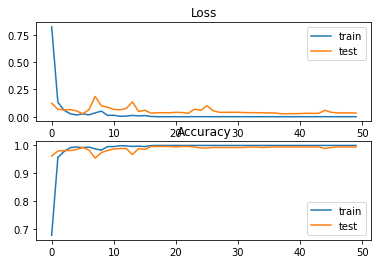

In [ ]:
import matplotlib.pyplot as pyplot


pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Input
from matplotlib import pyplot
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(224,224,3)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPool1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(1000))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(5, activation='softmax'))

scores, histories = list(), list()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

loss, acc, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

scores.append(acc)
histories.append(history)

NameError: ignored

In [ ]:
model.save('/content/drive/MyDrive/model/mymodel_ltsm_2.h5')

KeyError: ignored

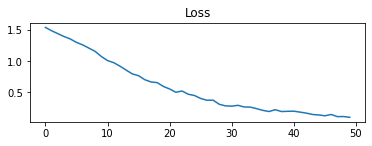

In [ ]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training


KeyError: ignored

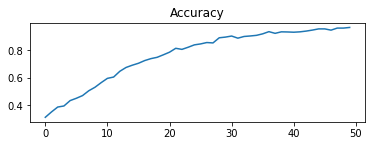

In [ ]:
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.evaluate(X_test, y_test, verbose=0)

[3.199032783508301,
 0.5018181800842285,
 0.5047397613525391,
 0.5096326470375061,
 0.5]